In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
import os

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)
os.makedirs('outputs/gridsearch', exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Preprocess Data

In [7]:
# Load thyroid data
df = pd.read_csv('thyroid/new-thyroid.data', header=None)
df.columns = ['Class', 'T3_resin', 'Thyroxin', 'Triiodothyronine', 'TSH', 'TSH_diff']

print(f"Dataset shape: {df.shape}")
print(f"\nOriginal Class distribution:")
print(df['Class'].value_counts())

# Convert multi-class to binary: 1 = normal, 2,3 = abnormal
df['Binary_Class'] = (df['Class'] == 1).astype(int)

print(f"\nBinary Class distribution (1=Normal, 0=Abnormal):")
print(df['Binary_Class'].value_counts())

# Features and target
X = df.drop(['Class', 'Binary_Class'], axis=1)
y = df['Binary_Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data preprocessed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

Dataset shape: (215, 6)

Original Class distribution:
Class
1    150
2     35
3     30
Name: count, dtype: int64

Binary Class distribution (1=Normal, 0=Abnormal):
Binary_Class
1    150
0     65
Name: count, dtype: int64

✓ Data preprocessed
Training set: (150, 5)
Test set: (65, 5)
Class distribution - Train: [ 45 105]
Class distribution - Test: [20 45]


## 2. Define Hyperparameter Grids

In [8]:
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
}

classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("✓ Hyperparameter grids defined")

✓ Hyperparameter grids defined


## 3. Perform GridSearchCV

In [9]:
grid_results = {}

print("="*80)
print("THYROID DISEASE - HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*80)

for name in classifiers.keys():
    print(f"\n{'='*80}")
    print(f"GridSearchCV: {name}")
    print(f"{'='*80}")
    
    grid_search = GridSearchCV(
        classifiers[name], 
        param_grids[name], 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    grid_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_,
        'test_accuracy': accuracy_score(y_test, grid_search.predict(X_test_scaled)),
        'test_f1': f1_score(y_test, grid_search.predict(X_test_scaled)),
        'variance': np.var(grid_search.cv_results_['mean_test_score']),
        'std': np.std(grid_search.cv_results_['mean_test_score']),
        'range': np.ptp(grid_search.cv_results_['mean_test_score'])
    }
    
    print(f"Best CV: {grid_results[name]['best_score']:.4f}")
    print(f"Test Acc: {grid_results[name]['test_accuracy']:.4f}")
    print(f"Sensitivity - Var: {grid_results[name]['variance']:.6f}, Range: {grid_results[name]['range']:.4f}")

print("\n✓ GridSearchCV completed")

THYROID DISEASE - HYPERPARAMETER SENSITIVITY ANALYSIS

GridSearchCV: KNN
Best CV: 0.9333
Test Acc: 0.9846
Sensitivity - Var: 0.000693, Range: 0.1067

GridSearchCV: Logistic Regression
Best CV: 0.9200
Test Acc: 0.8923
Sensitivity - Var: 0.027753, Range: 0.6200

GridSearchCV: SVM
Best CV: 0.9333
Test Acc: 0.9846
Sensitivity - Var: 0.000693, Range: 0.1067

GridSearchCV: Logistic Regression
Best CV: 0.9200
Test Acc: 0.8923
Sensitivity - Var: 0.027753, Range: 0.6200

GridSearchCV: SVM
Best CV: 0.9733
Test Acc: 0.9385
Sensitivity - Var: 0.006572, Range: 0.2733

GridSearchCV: MLP
Best CV: 0.9733
Test Acc: 0.9385
Sensitivity - Var: 0.006572, Range: 0.2733

GridSearchCV: MLP
Best CV: 0.9800
Test Acc: 0.9385
Sensitivity - Var: 0.000393, Range: 0.0533

GridSearchCV: Decision Tree
Best CV: 0.9800
Test Acc: 0.9385
Sensitivity - Var: 0.000393, Range: 0.0533

GridSearchCV: Decision Tree
Best CV: 0.9667
Test Acc: 0.8615
Sensitivity - Var: 0.000428, Range: 0.0733

GridSearchCV: Naive Bayes
Best CV: 0.9

## 4. Summary & Visualizations


SENSITIVITY RANKING - THYROID DISEASE
         Classifier  Best CV Score  Test Accuracy  Test F1  Variance  Std Dev  Range
Logistic Regression         0.9200         0.8923   0.9213    0.0278   0.1666 0.6200
                SVM         0.9733         0.9385   0.9535    0.0066   0.0811 0.2733
                KNN         0.9333         0.9846   0.9890    0.0007   0.0263 0.1067
                MLP         0.9800         0.9385   0.9545    0.0004   0.0198 0.0533
      Decision Tree         0.9667         0.8615   0.8889    0.0004   0.0207 0.0733
        Naive Bayes         0.9400         0.9231   0.9451    0.0000   0.0000 0.0000


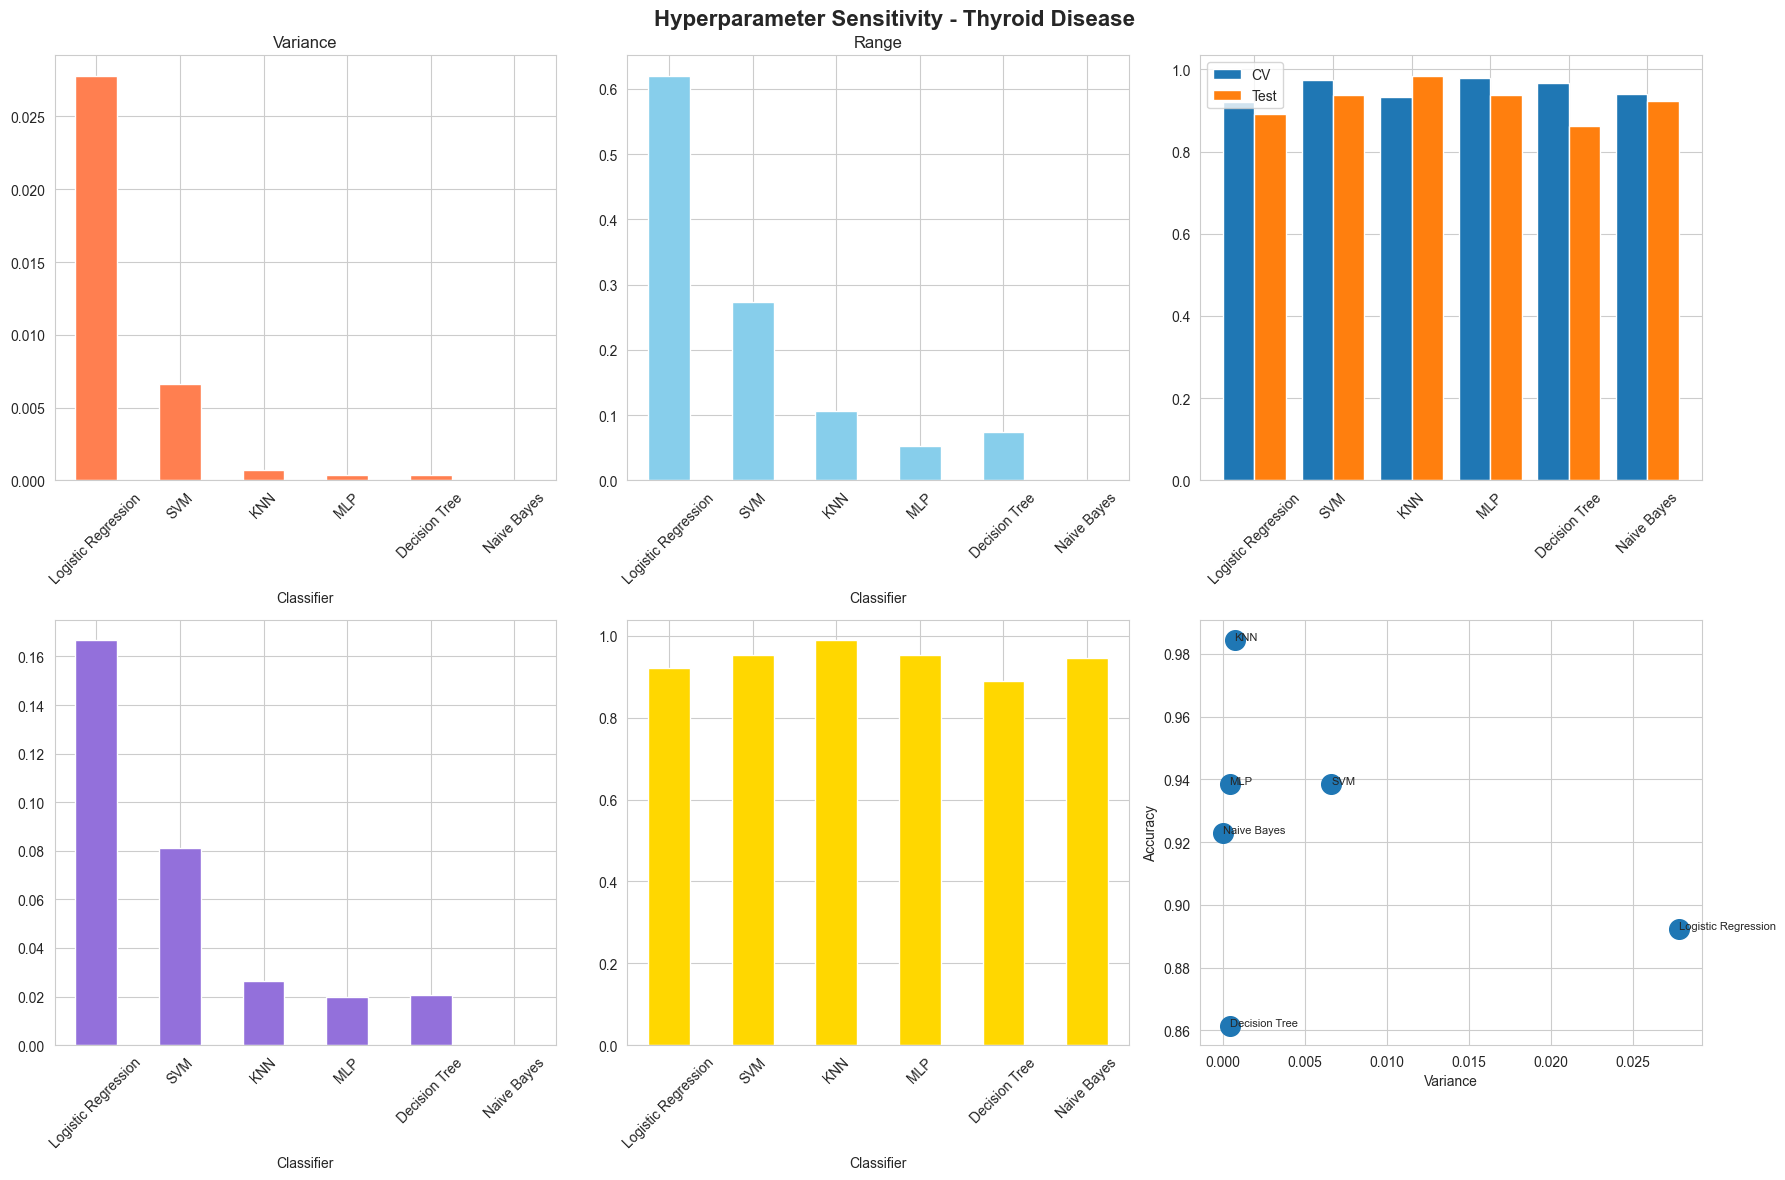


✓ Analysis complete


In [10]:
sensitivity_summary = pd.DataFrame({
    'Classifier': list(grid_results.keys()),
    'Best CV Score': [grid_results[n]['best_score'] for n in grid_results],
    'Test Accuracy': [grid_results[n]['test_accuracy'] for n in grid_results],
    'Test F1': [grid_results[n]['test_f1'] for n in grid_results],
    'Variance': [grid_results[n]['variance'] for n in grid_results],
    'Std Dev': [grid_results[n]['std'] for n in grid_results],
    'Range': [grid_results[n]['range'] for n in grid_results]
}).round(4).sort_values('Variance', ascending=False)

print("\nSENSITIVITY RANKING - THYROID DISEASE")
print("="*80)
print(sensitivity_summary.to_string(index=False))

sensitivity_summary.to_csv('outputs/results/thyroid_sensitivity.csv', index=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyperparameter Sensitivity - Thyroid Disease', fontsize=16, fontweight='bold')

sensitivity_summary.plot(x='Classifier', y='Variance', kind='bar', ax=axes[0,0], color='coral', legend=False)
axes[0,0].set_title('Variance')
axes[0,0].tick_params(axis='x', rotation=45)

sensitivity_summary.plot(x='Classifier', y='Range', kind='bar', ax=axes[0,1], color='skyblue', legend=False)
axes[0,1].set_title('Range')
axes[0,1].tick_params(axis='x', rotation=45)

x_pos = np.arange(len(sensitivity_summary))
axes[0,2].bar(x_pos - 0.2, sensitivity_summary['Best CV Score'], 0.4, label='CV')
axes[0,2].bar(x_pos + 0.2, sensitivity_summary['Test Accuracy'], 0.4, label='Test')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(sensitivity_summary['Classifier'], rotation=45)
axes[0,2].legend()

sensitivity_summary.plot(x='Classifier', y='Std Dev', kind='bar', ax=axes[1,0], color='mediumpurple', legend=False)
axes[1,0].tick_params(axis='x', rotation=45)

sensitivity_summary.plot(x='Classifier', y='Test F1', kind='bar', ax=axes[1,1], color='gold', legend=False)
axes[1,1].tick_params(axis='x', rotation=45)

axes[1,2].scatter(sensitivity_summary['Variance'], sensitivity_summary['Test Accuracy'], s=200)
for _, row in sensitivity_summary.iterrows():
    axes[1,2].annotate(row['Classifier'], (row['Variance'], row['Test Accuracy']), fontsize=8)
axes[1,2].set_xlabel('Variance')
axes[1,2].set_ylabel('Accuracy')

plt.tight_layout()
plt.savefig('outputs/figures/thyroid_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Analysis complete")

## 5. Save Detailed GridSearch Results

In [11]:
for name in grid_results.keys():
    cv_results = grid_results[name]['cv_results']
    results_df = pd.DataFrame(cv_results)
    results_df.to_csv(f'outputs/gridsearch/thyroid_{name.replace(" ", "_").lower()}_gridsearch.csv', index=False)

print("✓ Detailed GridSearch results saved to outputs/gridsearch/")
print("\n" + "="*80)
print("✓ Analysis complete for Thyroid Disease dataset")
print("="*80)

✓ Detailed GridSearch results saved to outputs/gridsearch/

✓ Analysis complete for Thyroid Disease dataset
